# Search Umbra SAR Archive

Searching Archive requires an API Token!
https://docs.canopy.umbra.space/docs/migrate-to-stac-api-v2

You can *browse* public data (a static STAC catalog), but not search it:
https://registry.opendata.aws/umbra-open-data/

In [1]:
import geopandas as gpd
import pystac_client
import stac_asset
import stac_geoparquet
import os
from IPython.display import Image

In [2]:
# Search for acquisitions in AWS Open Data Catalog
# NOTE: different endpoint, but still need auth
stac_api_url = "https://api.canopy.umbra.space/archive/"
archive = pystac_client.Client.open(stac_api_url,
                                    headers={"authorization": f"Bearer {os.environ.get('UMBRA_API_TOKEN')}" }
)
#archive

## Search CONUS

In [3]:
cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

# NOTE: testing API request limits
#limit_results=10000 #APIError: upstream request timeout
#limit_results=5000 #APIError: upstream request timeout
limit_results=2000 #works
#limit_results=1000 #works

stac_search = archive.search(
    bbox='-124.84, 24.39, -66.88, 49.38',
    filter=cql2filter,
    #NOTE: seems this must be set to>= max_items, else 'Unauthorized'
    max_items=limit_results,
    limit=limit_results,
)

items = stac_search.item_collection()


In [4]:
def items_to_dataframe(items):
    # STAC Item ID should be only at top level, not under 'properties'
    # Still 'valid' according to items[0].validate(), but messes up stac-geoparquet parsing
    #_ = [i.properties.pop('id', None) for i in items]

    # Alternatively, rename this field as 'archive_id' since it's different from task_id, collect_id, etc.
    for i in items:
        i.properties['umbra:archive_id'] = i.properties.pop('id')

    record_batch_reader = stac_geoparquet.arrow.parse_stac_items_to_arrow(items)
    gf = gpd.GeoDataFrame.from_arrow(record_batch_reader)

    return gf

In [5]:
# Stac-geoparquet to geodataframe (include assets, links, ids etc)
#gf = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
#len(gf)

gf = items_to_dataframe(items)
gf.head()

,assets,bbox,collection,geometry,id,links,stac_extensions,stac_version,type,created,...,umbra:open-data-catalog,umbra:slant_range_kilometers,umbra:squint_angle_degrees,umbra:squint_angle_degrees_off_broadside,umbra:squint_angle_engineering_degrees,umbra:squint_angle_exploitation_degrees,umbra:target_azimuth_angle_degrees,umbra:task_id,updated,view:incidence_angle
0,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -111.86013316011781, 'ymin': 39.04871...",umbra-sar,"POLYGON Z ((-111.86013 39.07407 1538.89866, -1...",1bd95e48-8057-4648-977d-0a1f051c5657,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-05 23:53:16.564706+00:00,...,True,717.313416,160.336349,19.663651,-70.336349,19.663651,305.377930,e36b190f-7453-46fc-a0d1-97a37d51ee2e,2025-03-05 23:53:16.564708+00:00,39.830414
1,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -110.84257655853519, 'ymin': 43.71158...",umbra-sar,"POLYGON Z ((-110.81867 43.71159 4146.31813, -1...",c620efed-590b-40da-9525-cec4ee9f2165,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-06 10:51:43.263187+00:00,...,True,521.152832,-145.066208,34.933800,-124.933800,-34.933800,249.350769,1219040d-db58-4877-b83d-384c828b89e1,2025-03-06 10:51:43.263189+00:00,23.002808
2,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -93.7537327797179, 'ymin': 41.6547102...",umbra-sar,"POLYGON Z ((-93.67425 41.69572 223.05129, -93....",a33bcaf8-cadd-4912-860b-b791becc8e8a,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-06 05:54:46.353396+00:00,...,True,591.161804,-12.829918,12.829918,102.829918,-12.829918,113.022919,5ef6f649-e638-478d-9a69-d2eb84aaeed5,2025-03-06 05:54:46.353399+00:00,36.159500
3,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -77.8319733781578, 'ymin': 34.1781373...",umbra-sar,"POLYGON Z ((-77.75909 34.21838 -36.59204, -77....",690bf84d-8c6f-4e5e-bb65-375ccadccf47,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-06 08:33:01.081867+00:00,...,True,612.247559,135.732117,44.267879,-45.732121,44.267879,120.622871,cabc3b00-d0b1-4569-9825-f8e9bcb882f5,2025-03-06 08:33:01.081869+00:00,37.508770
4,{'thumbnail': {'description': 'Low-resolution ...,"{'xmin': -121.81798219289902, 'ymin': 38.50622...",umbra-sar,"POLYGON Z ((-121.7516 38.55059 -9.90276, -121....",c7bd014a-7779-43f8-998a-9d1d50ac93f3,[{'href': 'https://api.canopy.umbra.space/arch...,[https://stac-extensions.github.io/view/v1.0.0...,1.1.0,Feature,2025-03-05 03:40:44.894648+00:00,...,True,720.738770,5.388874,5.388878,84.611122,5.388878,94.381454,14497a76-df3a-489f-b8ba-8c59afa49373,2025-03-05 03:40:44.894651+00:00,39.943420


In [6]:
gf.iloc[0]

assets                                      {'thumbnail': {'description': 'Low-resolution ...
bbox                                        {'xmin': -111.86013316011781, 'ymin': 39.04871...
collection                                                                          umbra-sar
geometry                                    POLYGON Z ((-111.86013316011781 39.07407009460...
id                                                       1bd95e48-8057-4648-977d-0a1f051c5657
links                                       [{'href': 'https://api.canopy.umbra.space/arch...
stac_extensions                             [https://stac-extensions.github.io/view/v1.0.0...
stac_version                                                                            1.1.0
type                                                                                  Feature
created                                                      2025-03-05 23:53:16.564706+00:00
datetime                                                    

In [7]:
i = items[-1]
i.assets

{'thumbnail': <Asset href=https://api.canopy.umbra.space/archive/thumbnail/dce419d0-fb28-41cc-9dae-5221aab83f3e>}

In [8]:
len(gf)

1683

### Notes

* Currently 1683 acquisitions in public data archive
* Unfortunately only thumbnails in assets!

Hmmm,,, So this catalog is different from the static STAC catalog here (which lists all assets...)
https://radiantearth.github.io/stac-browser/#/external/s3.us-west-2.amazonaws.com/umbra-open-data-catalog/stac/2025/2025-01/2025-01-04/7f40db7e-8e11-487e-8fbb-3985338f542b/7f40db7e-8e11-487e-8fbb-3985338f542b.json

## Search WA State

In [9]:
# Search for all acquisitions in WA State

aoi = gpd.read_file('https://raw.githubusercontent.com/unitedstates/districts/refs/heads/gh-pages/states/WA/shape.geojson')
aoi.explore()

In [10]:
cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

limit_results=2000

stac_search = archive.search(
    #filter=cql2filter,
    max_items=limit_results,
    limit=limit_results,
    intersects=aoi.geometry.iloc[0],
)

items = stac_search.item_collection()
gf = items_to_dataframe(items)
len(gf)

96

In [11]:
gf.explore(column='umbra:open-data-catalog', cmap='plasma', popup=True)

In [12]:
gf.iloc[0]

assets                                      {'thumbnail': {'description': 'Low-resolution ...
bbox                                        {'xmin': -121.79075463596307, 'ymin': 46.76506...
collection                                                                          umbra-sar
geometry                                    POLYGON Z ((-121.79075463596307 46.79467073674...
id                                                       4def2457-ca86-4cbf-bb65-e71189cc8001
links                                       [{'href': 'https://api.canopy.umbra.space/arch...
stac_extensions                             [https://stac-extensions.github.io/view/v1.0.0...
stac_version                                                                            1.1.0
type                                                                                  Feature
created                                                      2025-03-01 23:44:05.462422+00:00
datetime                                                    

### Display thumbnails

4def2457-ca86-4cbf-bb65-e71189cc8001


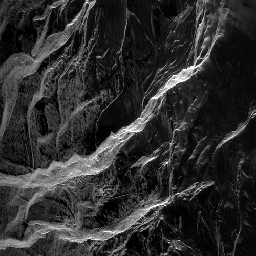

In [13]:
config = stac_asset.Config(
    http_headers={"authorization": f"Bearer {os.environ.get('UMBRA_API_TOKEN')}" }
)

item = gf.iloc[0]
img = await stac_asset.read_href(item.assets['thumbnail']['href'], config=config)
print(item.id)
Image(img)

## Point Search

In [14]:
# Search based on single point

# For example, is this bistatic pair public?...
# http://umbra-open-data-catalog.s3.amazonaws.com/sar-data/tasks/ad%20hoc/bistatic/tarbela_dam/2024-02-20-16-57-20.tif
# No, seems it's not in the catalog

aoi_as_dict = {
        "coordinates": [
          72.698,
          34.099
        ],
        "type": "Point"
      }

cql2filter = {
    "op": "=",
    "args": [
      {
        "property": "umbra:open-data-catalog"
      },
      True
    ]
  }

limit_results=2000

stac_search = archive.search(
    #filter=cql2filter,
    max_items=limit_results,
    limit=limit_results,
    intersects=aoi_as_dict,
)

items = stac_search.item_collection()
gf = items_to_dataframe(items)
len(gf)

2

In [15]:
gf.iloc[0]

assets                                      {'thumbnail': {'description': 'Low-resolution ...
bbox                                        {'xmin': 72.6741499645369, 'ymin': 34.05658251...
collection                                                                          umbra-sar
geometry                                    POLYGON Z ((72.73966216664009 34.1003607578395...
id                                                       f5c610ed-8880-49a0-880c-12b2296201e8
links                                       [{'href': 'https://api.canopy.umbra.space/arch...
stac_extensions                             [https://stac-extensions.github.io/view/v1.0.0...
stac_version                                                                            1.1.0
type                                                                                  Feature
created                                                      2024-03-06 19:57:37.840927+00:00
datetime                                                    